# Đây là một notebook được làm để luyện tập bài tập Titanic phân loại người sống còn của Hwang Trung
Notebook này được lấy cảm hứng từ: https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Oke bây giờ ta sẽ đọc dữ liệu

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

### Tiếp theo: ta sẽ phân tích bằng mô tả dữ liệu
_Ta sẽ coi xem có những features gì_

In [3]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

### Có 2 câu hỏi được đặt ra là: feature nào là liệt kê và feature nào là số??
_Feature liệt kê sẽ phân loại các mẫu thành các samples nhỏ : Survived, Sex và Embarked. Thứ tự: Pclass
Feature số là các giá trị thay đổi theo từng mẫu, chúng có thể là rời rạc, liên tục hoặc dựa trên timeseries._
`Liên tục: Age, Fare`
`Rời rạc: SibSp, Parch`

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature nào là `mixed data types` và feature nào `chứa errors và typos`?
`Feature số và thứ tự` => ta có thể dùng nó để đạt được 'goal'
`Feature TÊN` có thể chứa lỗi: vì sao? vì chúng có thể có nhiều cách để miêu tả 1 cái tên như tên thường gọi ở nhà, tên thường gọi ghép với bố mẹ, hoặc đơn giản gọi tên cực ngắn.

In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Feature nào chứa `blank,null hoặc empty`?  
Cabin>Age>Embarked chứa khá nhiều dữ liệu trống
Cabin>Age là những tập dữ liệu chưa hoàn thiện
### Kiểu dữ liệu nào chứa `various features`?
7 features là số,5 features là strings

In [6]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

### Classifying Assumption - Tóm tắt lại ta có gì?
- Số mẫu là 891/2224 số mẫu thật (40% số hành khách có mặt trên Titanic)
- Sống hay không sống, không sống hay sống nói 1 lời (hai giá trị 0,1)
- Khoảng 38% mẫu sống => tỉ lệ sống còn là 32%.
- Hầu hết hành khác không đi du lịch với pố mẹ hoặc con cái (>75%)
- Gần 30% hành khách có chị em họ hoặc vợ/chồng (spouse).
- Giá vé biến thiên với vài hành khách (<1%) giàu: 512$
- Vài người lớn tuổi (<1%) được xếp vào độ tuổi 65-80

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Nhìn vào bảng trên, ta thấy:
- Tên (PassengerId): độc nhất vô nhị (891 cái tên)
- Giới tính chỉ có 2 giá trị (65% male, 577/891 mẫu)
- Feature cabin thì có lặp lại => Có vài hành khách share cabin
- Embarked có 3 giá trị (hạnh thường, trung lưu và hạng sang). Hạng S chiếm đa số.
- Feature ticket chiếm tỉ lệ lặp lại cao (22%,681/891).

In [8]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Johansson, Mr. Karl Johan",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


# Tổng kết lại ta thấy rằng:

### Correlations - Sự tương quan
Ta muốn biết các feature tương quan lẫn nhau đến `Sống sót`. Ta cần xác định để áp dụng chúng vào mô hình dự đoán.

### Completing - Hoàn thiên
1. Ta cần hoàn thiện Age vì nó chắc chắn liên quan đến `Survival`.
2. Ta cần hoàn thiện cả Embarked vì nó có thể liên quan đến `Survival` và `feature quan trọng khác`.

### Correction - Chỉnh sửa bảng (loại pỏ)
1. Feature ticket có thể bị bỏ vì chúng lặp lại khá nhiều (22%). Điều này có thể làm cho feature này không tương quan đến `Ticket` và `Survival`.
2. Feature Cabin có thể bị bỏ vì chứa wá nhiều giá trị __null__.
3. Ta có thể bỏ `PassengerId` vì chúng không liên wan lắm đến `Survival`.
4. Feature `Name` không liên wan gì đến nhau, có thể không ảnh hưởng trực tiếp đến sự sống sót, ta có thể pỏ.

### Creating - Khởi tạo
1. Ta có thể tạo ra feature mới gọi là `Family` dựa trên `Parch` và `SibSp` để lấy được thành viên gia đình đi tàu.
2. Từ `Name` ta có thể tách thành `Title` (danh hiệu)
3. Ta có thể tạo ra feature mới từ `Age` => feature số liên tục thành một feature theo thứ tự.
4. `Fare` ta có thể tạo thành `Fare range`

### Classification - Phân loại
1. __Woman__ (`Sex` = 'female') gần như có khả năng sống sót _(Đúng mà, toàn nhường trẻ con và phụ nữ lên tàu cứu hộ trước nè)_.
2. __Children__(`Age` < ?) cũng có khả năng sống sót _(Vì sao,vì trẻ con như púp trên cành)_.
3. Tầng lớp thượng lưu (`Pclass`= 1) cũng có khả năng sống sót _(No cần answer =)) )_.

# Oke bây giờ thử phân tích bằng pivoting features
Để xác nhận những điều ta rút ra ở trên, ta có thể phân tích nhanh sự tương wan bằng so sánh pivoting features từng cái với nhau. Ta chỉ có thể làm với những cái features nào không có giắ trị __null__ : `Sex` (liệt kê); `Pclass` (theo thứ tự); `SibSP`,`Parch` (rời rạc)

- `Pclass`: Ta cần sự tương quan cụ thể (>0.5) giữa class `Pclass` = __1__ và `Survived` (classifying #3). Oke chọn 2 cái này.
- `Sex`: Ta thấy phụ nữ có cơ hội sống sót cao hơn (74%) (classifying #1)
- `SipSp` và `Parch`: Những feature này không có sự tương quan với bất kì giá trị khác. Hai features này có thể tạo ra 1 hoặc một vài features khác (creating #1)

In [9]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Vẽ hình (Visualizing data) và Phân tích
### Tương quan giữa các features số
Cũng tương tự ở trên thôi, nhưng ta sẽ dùng histogram vì chart này giúp ta phân tích được những biến số liên tục như `Age`

#### Quan sát tý
- Trẻ sơ sinh (Age<=4) có tỉ lệ sống sót cao. 
- Người già (Age = 80) cũng sống sót.
- Số lượng lớn người có độ tuổi 15-25 không sống sót.
- Chủ yếu hành khác lại ở độ tuổi 15-35.

#### Quyết định
- Chọn `Age` (classifying #2)
- Hoàn thành `Age`, điền đầy đủ cho __null__ (completing #1)
- Gộp nhóm tuổi `Age range` (creating #3)

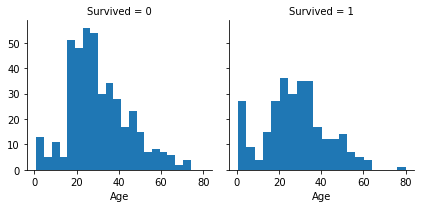

In [13]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Tương quan giữa các feature số và thứ tự
#### Quan sát
- `Pclass`= 3 có nhiều hành khách nhất, tuy nhiên đều khó lòng sống sót. Chứng minh cho điều ta đoán ở trên Classifying Assumption #2.
- Trẻ sơ sinh ở `Pclass` = 2 và `Pclass` = 3 cũng sống sót. Đủ điều kiện cho CA #2.
- Hầu hết hành khách ở `Pclass` = 1 sống sót.
- `Pclass` thì lại khác nhau ở phân bố độ tuổi.

#### Quyết định
- Chọn `Pclass` thôi chần chờ gì nữa.

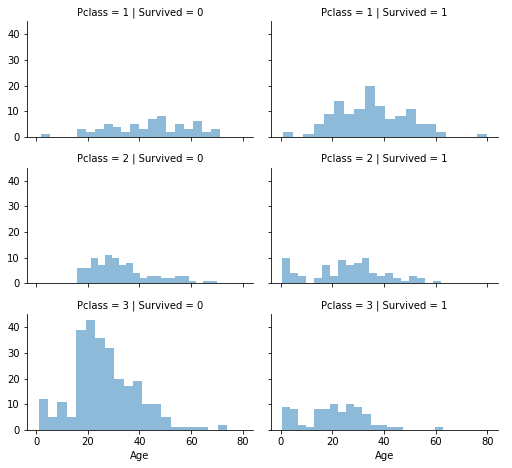

In [14]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Tương quan giữa các feature liệt kê
#### Quan sát nào !!!
- Như trên, phụ nữ sống sót cao hơn (Bao gồm cả Rose).
- Trừ `Embarked` = C thì đàn ông có tỉ lệ sống sót cao hơn. Điều này có nghĩa có thể có sự tương quan giữa `Pclass` và `Embarked`, nhưng không ảnh hưởng trực tiếp `Embarked` đến `Survived`.
- Đàn ông ở `Pclass` = 3 khi so sánh với `Pclass` = 2 ở bến tàu C và Q. Completing #2.
- Bến xuống thì đa dạng hơn với `Pclass` = 3 giữa các hành khách nam. Correlation #1.

#### Quyết định là:
- Cho `Sex` vô.
- Hoàn thiện `Embarked` và cho vô mô hình training.

c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

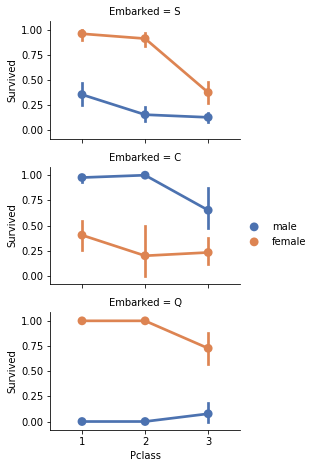

In [15]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Tương quan giữa các features số và liệt kê
#### Quan sát thôi bé ơi
- Hành khách giả tiền vé cao thì có cơ hội sống sót cao. Confirm cho creating #4
- Cảng tàu cũng có tương quan đến tỉ lệ sống sót. Confirm cho correlating #1 và completing #2.

#### Quyết định 
- Fare nên tạo thành các khoảng.

c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


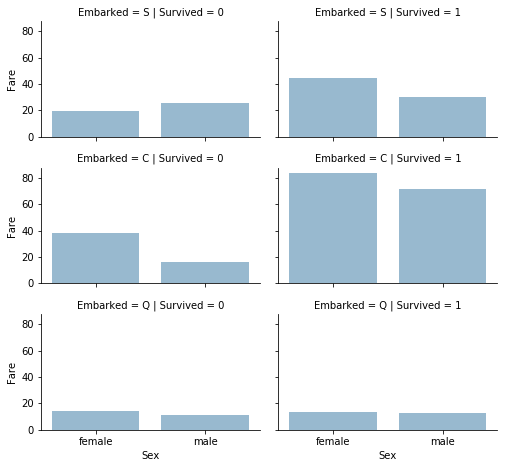

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Wrangle Data
Oke vậy là chúng ta đã đưa ra một số nhận định và quyết định cho tập datasets và giải quyết những yêu cầu. Nhưng ta chưa thay đổi gì, nên... bắt tay vào làm thôiiiiii
### Correcting bằng cách loại bỏ features
Như trên ta cần bỏ cái feature `Cabin` (correcting #2) và `Ticket` (correcting #1) features.
> Note: ta cần loại bỏ ở cả tập train và test để thích hợp

In [17]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

### Creating những _feature mới_ bằng từ _feature cũ_
Tách `Name` và `PassengerId` thành `Title` bằng Regex `(\w+\)`. `expand=FALSE` để trả lại 1 Dataframe.

#### Quan sát nào:
Khi ta vẽ `Title`,`Age` và `Survived`. ta thấy như sau:
- Mỗi `Title` của khoảng độ tuổi phân nhóm chính xác. VD: Master title có Age mean() 5 năm.
- Người sống sót ở khoảng độ tuổi biến thiên khá nhẹ.
- Có những title hầu như đều sống sót (Mme, Lady, Sir) hoặc đều không sống sót (Don, Rev, Johnkheer).

#### Quyết định của chúng ta là:
- Chọn `Title` cho mô hình của chúng ta.

In [18]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40




Ta có thể thay title mới những cái tên thông thường hoặc phân loại chúng là `Rare`

In [19]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Ta có thể chuyển đổi titles liệt kê thành các số thứ tự

In [20]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Bây giờ thì ta vứt cái `Name` và `PassengerId` khỏi tập train và test.

In [21]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Chuyển đổi 1 feature liệt kê
Bây giờ ta có thể biến đổi features gồm `chuỗi` thành các giá trị số. Điều này khá cần thiết với hầu hết mô hình toán học. Làm điều này sẽ giúp ta tiến tới goal hơn.
Mapping `Sex` thành nhị phân trước sẽ như sau

In [22]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing feature số liên tục
Bây giờ ta nên bắt đầu ước chừng và hoàn thiện nốt các features còn thiếu hoặc có giá trị __null__. Làm `Age` trước nhé.


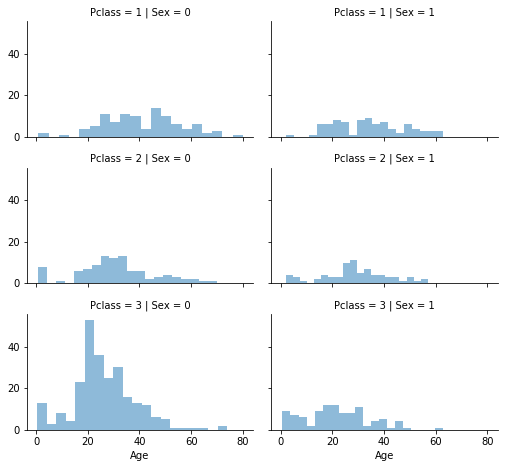

In [23]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [24]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [25]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [26]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [27]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [28]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [29]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [30]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [31]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [32]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [33]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [34]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [35]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [36]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [37]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [38]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [39]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


In [40]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [41]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

c:\users\trung\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


80.36

In [42]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287163
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311200
0,Pclass,-0.749007


In [43]:
# Support Vector Machines

# svc = SVC()
# svc.fit(X_train, Y_train)
# Y_pred = svc.predict(X_test)
# acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
# acc_svc

In [44]:
# knn = KNeighborsClassifier(n_neighbors = 3)
# knn.fit(X_train, Y_train)
# Y_pred = knn.predict(X_test)
# acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
# acc_knn

In [45]:
# # Gaussian Naive Bayes

# gaussian = GaussianNB()
# gaussian.fit(X_train, Y_train)
# Y_pred = gaussian.predict(X_test)
# acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
# acc_gaussian

In [46]:
# # Perceptron

# perceptron = Perceptron()
# perceptron.fit(X_train, Y_train)
# Y_pred = perceptron.predict(X_test)
# acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
# acc_perceptron

In [47]:
# # Linear SVC

# linear_svc = LinearSVC()
# linear_svc.fit(X_train, Y_train)
# Y_pred = linear_svc.predict(X_test)
# acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
# acc_linear_svc

In [53]:
# # Stochastic Gradient Descent

# sgd = SGDClassifier()
# sgd.fit(X_train, Y_train)
# Y_pred = sgd.predict(X_test)
# acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
# acc_sgd

In [54]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

In [56]:
# Random Forest

# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(X_train, Y_train)
# Y_pred = random_forest.predict(X_test)
# random_forest.score(X_train, Y_train)
# acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
# acc_random_forest

86.76

In [51]:
# models = pd.DataFrame({
#     'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
#               'Random Forest', 'Naive Bayes', 'Perceptron', 
#               'Stochastic Gradient Decent', 'Linear SVC', 
#               'Decision Tree'],
#     'Score': [acc_svc, acc_knn, acc_log, 
#               acc_random_forest, acc_gaussian, acc_perceptron, 
#               acc_sgd, acc_linear_svc, acc_decision_tree]})
# models.sort_values(by='Score', ascending=False)

In [52]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)